This document seeks to summarize work on the $[\![4,2,2]\!]$ quantum error detection (QED) code done as part of a summer project. Simulations of the code are done with IBM's module Qiskit, which is required to run the notebook. To install it, simply run *pip install qiskit*

The code was written mainly by Alexander Andersson as well as Sebastian Holmin.
Main author of this notebook is Alexander Andersson.



In [2]:
# %% Import modules
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
import warnings

# Qiskit modules/packages
from qiskit import *

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.library import save_density_matrix, save_expectation_value
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import state_fidelity

# Local files
from simulator_program.custom_noise_models import (thermal_relaxation_model_V2,
                                                   standard_times,
                                                   standard_times_delay,
                                                   GateTimes)
from simulator_program.custom_transpiler import (cross_device_properties,
                                                 shortest_transpile_from_distribution)
from simulator_program.data_analysis_tools import (default_execute,
                                                   overlap_with_subspace)
from simulator_program.stabilizers import *
from simulator_program.post_select import (get_trivial_post_select_counts_V2,
                                           get_trivial_post_select_counts,
                                           get_trivial_post_select_den_mat,
                                           get_trivial_exp_value)
from simulator_program.post_process import *
from simulator_program.idle_noise import add_idle_noise_to_circuit, get_circuit_time
from simulator_program.logical_gates_422 import *



Adding custom device equivalences


Without going into much detail about the functionality of the Qiskit module, we start with defining some functions used for calculations. The first function uses a variety of functions from local files to define the circuit, noise model, etc.

In [3]:
def fidelity_from_scratch_422(n_cycles, n_shots, gate_times={}, T1=40e3, T2=60e3,
                          idle_noise=True,
                          snapshot_type='dm',
                          transpile=True, 
                          device_properties=cross_device_properties,
                          initial_state=[1.,0.,0.,0.], 
                          simulator_type='density_matrix',
                          project=False, **kwargs):
    """Get the fidelity of a certain setup/configuration from only some basic
    parameters and settings.

    Args:
        n_cycles (int): The number of stabilizer cycles to be performed.
        n_shots (int): The number of runs of the circuit.
        gate_times: Can be either a dict with some gate times (in ns), or a
                    GateTimes object. If it is a dict, gate times not included 
                    will be added from standard gate times.
        T1 (float): T1 thermal relaxation constant. (Amplitude damping)
        T2 (float): T2 thermal relaxation constant. (Phase damping)
        idle_noise (bool): Whether or not to add thermal relaxation noise to 
                           idle qubits. This follows the T1 and T2 specified. 
                           Defaults to True.
        snapshot_type (str): The type of snapshots to add to circuit. Possible
                             options are 'dm' or 'denstiy_matrix' and
                             'exp' or 'expectation_value'. Defaults to 'dm'.
        transpile (bool): Whether or not to transpile the circuit.
        device_properties (dict): The set of properties to transpile circuit to
        initial_state (list): The initial two-qubit state, given as its
                              statevector. Defaults to [1., 0., 0., 0.].
        simulator_type (str): The type of simulation to run. Possible options
                              are 'statevector' or 'density_matrix'. Defaults
                              to 'density_matrix'. 
        project (bool): Whether to project density matrix snapshots to the code
                        space. This replaces the fid output with the logical
                        fidelity and adds P_L as an extra output.

    Possible kwargs:
        conditional (bool): Whether to separate snapshots based on measurement
                            outcomes. To do post-selection, this must be true.
                            Defaults to true.
        encoding (bool): Whether or not to perform the encoding circuit before
                         stabilizer cycles. If False, the logical state will
                         be perfectly initialized. Defaults to True.
        extra_snapshots (bool): Whether to include additional snapshots after
                                each stabilizer measurement. Defaults to False.
        include_barriers (bool): Whether or not to add barriers between certain
                                 segments of the circuit. This may prevent
                                 unwanted moving of gates. Defaults to True.
        pauliop (str): String corresponding to the observable whose expectation
                       value is measured in a snapshot (if snapshot type is
                       set to expectation value). Defaults to ZZZZ.
        reset (bool): Whether or not to reset ancilla between measurements.
                      defaults to True.

    Returns:
        fid (list): The average fidelity after each stabilizer cycle.
        select_counts (list): The remaining runs after each cycle.
        times: The time passed at each snapshot in the circuit
    """

    # Get gate times missing from input
    if isinstance(gate_times, dict):
        full_gate_times = standard_times.get_gate_times(
            custom_gate_times=gate_times)
    elif isinstance(gate_times, GateTimes):
        full_gate_times = gate_times
    else:
        warnings.warn('Invalid gate times, assuming standard_times')
        full_gate_times = standard_times

    # Manage kwargs used for circuit building
    default_kwargs = {'conditional': True,  
                      'encoding': True,
                      'extra_snapshots': False,
                      'include_barriers': True,
                      'pauliop': 'ZZZZ',
                      'reset': True,
                      'snapshot_type': snapshot_type} # DM if nothing specified
    for key in default_kwargs:
        if key not in kwargs:
            kwargs[key] = default_kwargs[key]

    # Noise model
    noise_model = thermal_relaxation_model_V2(
        T1=T1, T2=T2, gate_times=full_gate_times)

    # Build the circuit
    circ = get_full_stabilizer_circuit_422(n_cycles=n_cycles, 
                                       initial_state=initial_state,
                                       simulator_type=simulator_type,
                                       **kwargs)

    if transpile:
        circ = shortest_transpile_from_distribution(circ, print_cost=False,
                                                    **device_properties)

    # Get the correct (no errors) state
    trivial = get_encoded_state_422(initial_state, include_ancillas=None)

    # Add T1/T2 noise to idle qubits
    if idle_noise:
        circ, time = add_idle_noise_to_circuit(circ, gate_times=full_gate_times,
                                               T1=T1, T2=T2, return_time=True,
                                               **kwargs)
    else: 
        time = get_circuit_time(circ=circ, gate_times=full_gate_times)

    # Run the circuit
    simulator = Aer.get_backend('qasm_simulator')
    try:
        simulator.set_option('method', simulator_type)
    except:
        print('Invalid simulator type, defaulting to density_matrix')
        simulator.set_option('method', 'density_matrix')
    results = execute(circ, simulator,
                      noise_model=noise_model, shots=n_shots).result()

    # Get the number of remaining shot at each cycle
    select_counts = get_trivial_post_select_counts(results.get_counts(), n_cycles, '00')

    # Get the fidelity for each cycle
    fidelities = [] # If project = True, this contains F_L
    P_Ls = []
    
    if snapshot_type == 'dm' or snapshot_type == 'density_matrix':
        # TODO: Make this return F_L and P_L seperately and fix the references
        for state in get_trivial_post_select_den_mat(results, n_cycles, '00'):
            if project:
                state, P_L = project_dm_to_logical_subspace_422(state, return_P_L=True)
                P_Ls.append(np.real(P_L))
                state = get_encoded_state_422(np.diag(state), include_ancillas=None)
            fidelities.append(state_fidelity(state, trivial))
        if project:
            return fidelities, P_Ls, select_counts, time

    elif snapshot_type == 'exp' or snapshot_type == 'expectation_value':
        fidelities = [post_selected_state for
                      post_selected_state in get_trivial_exp_value(
                          results, n_cycles)]
    return fidelities, select_counts, time



def project_dm_to_logical_subspace_422(rho, return_P_L=False):
    """Project a 16x16 density matrix of a 4-qubit state onto the [[4,2,2]] 
    logical subspace.

    Args:
        rho (np.array): 16x16 density matrix corresponding to the 4-qubit state.
        return_P_L (bool): Option to also return the probability of being in the
                           code space i.e. the overlap with the logical states.
    Returns:
        rho_L (np.array): The 4x4 density matrix corresponding to the logical
                          2-qubit state.
    """
    P_L = 0
    logical = logical_states_422(include_ancillas=None)
    for i in range(len(logical)):
        P_L += logical[i] @ rho @ logical[i]
    rho_L = np.zeros((4, 4), dtype=complex)
    for i in range(len(logical)):
        for j in range(len(logical)):
            rho_L[i, j] = (logical[i] @ rho @ logical[j])/P_L
    if return_P_L:
        return rho_L, P_L
    return rho_L


While the first function *fidelity_from_scratch_422()* is handy, we'll instead start by manually going through the process of creating a circuit, configuring it, simulating and then looking at the results.

First, we build the circuit. We can do this with the local function *get_full_stabilizer_circuit_422()*, defined in *stabilizers.py*. Essentially it composes a circuit encoding a logical state, followed by stabilizer measurements and a final readout. It does have a variety of available settings, and for a full breakdown of how it works, refer to the documentation present there.

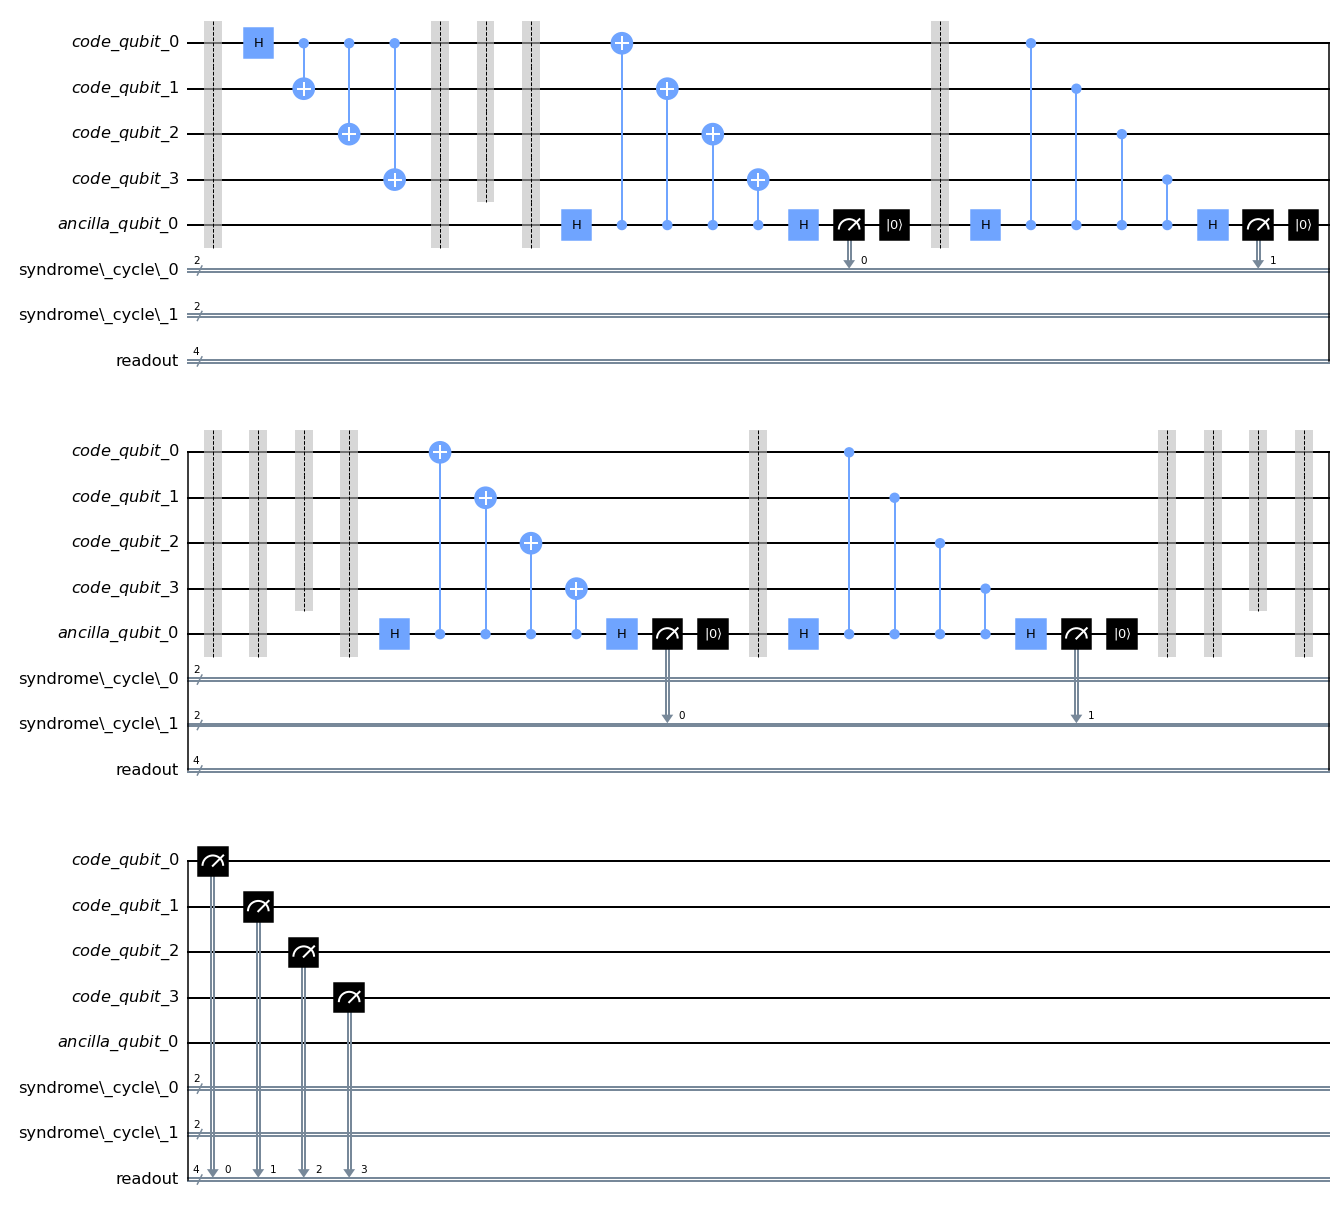

In [4]:
# Keyword arguments used for the circuit
kwargs = {'conditional': True, # Conditions snapshots on measurement results
          'encoding': True, # Performs the encoding scheme at the start, instead of perfectly initializing the logical state
          'reset': True, # (Perfectly) resets the ancilla qubit after measurement
          'snapshot_type': 'dm'} # Takes density matrix snapshots after each stabilizer cycle
initial_state = [1., 0., 0., 0.] # Encode the logical |00>_L state
n_cycles = 2
# Create the circuit object
circ = get_full_stabilizer_circuit_422(n_cycles=n_cycles, initial_state=initial_state, **kwargs)

# Draw the circuit
circ.draw(output='mpl')

So what the circuit does is encode the $\ket{00}_L = (\ket{0000}+\ket{1111})/\sqrt(2)$ state, followed by two cycles of stabilizer measurements. As a final step, the complete 4-qubit state is measured into a separate register. The grey vertical lines in the circuit represents either barriers or snapshots. When simulating the circuit, these snapshots will be saved to access the density matrix at those points in the circuit. Barriers prevent any gates to be moved past it, which helps ensure that everything works correctly. In general, snapshots are the lines only covering the four code qubits, while barriers also cover the ancilla. This is because we only snapshot the code qubit. We're not really intrested in the ancilla.

Note however, that this circuit allows any gate and full connectivity. To decompose the circuit into a specific configuration of gates and layout, we use *shortest_transpile_from_distribution()*, defined in *custom_transpiler.py*.

Qiskit has its own transpiler with different optimization levels. As it works stochastically, our function calls it a number of times and selects the shortest circuit achieved.

Here, we choose to transpile to a cross connectivity, with one qubit at the center connected to four others. We also transpile to the gate set $$G = \{{CZ}, \mathrm{iSWAP}, {X}, {Y}, {Z(\theta)},  {\sqrt{X}},{\sqrt{Y}\}}.$$

Both of these options are store in *cross_device_properties*, imported from *custom_transpiler.py*

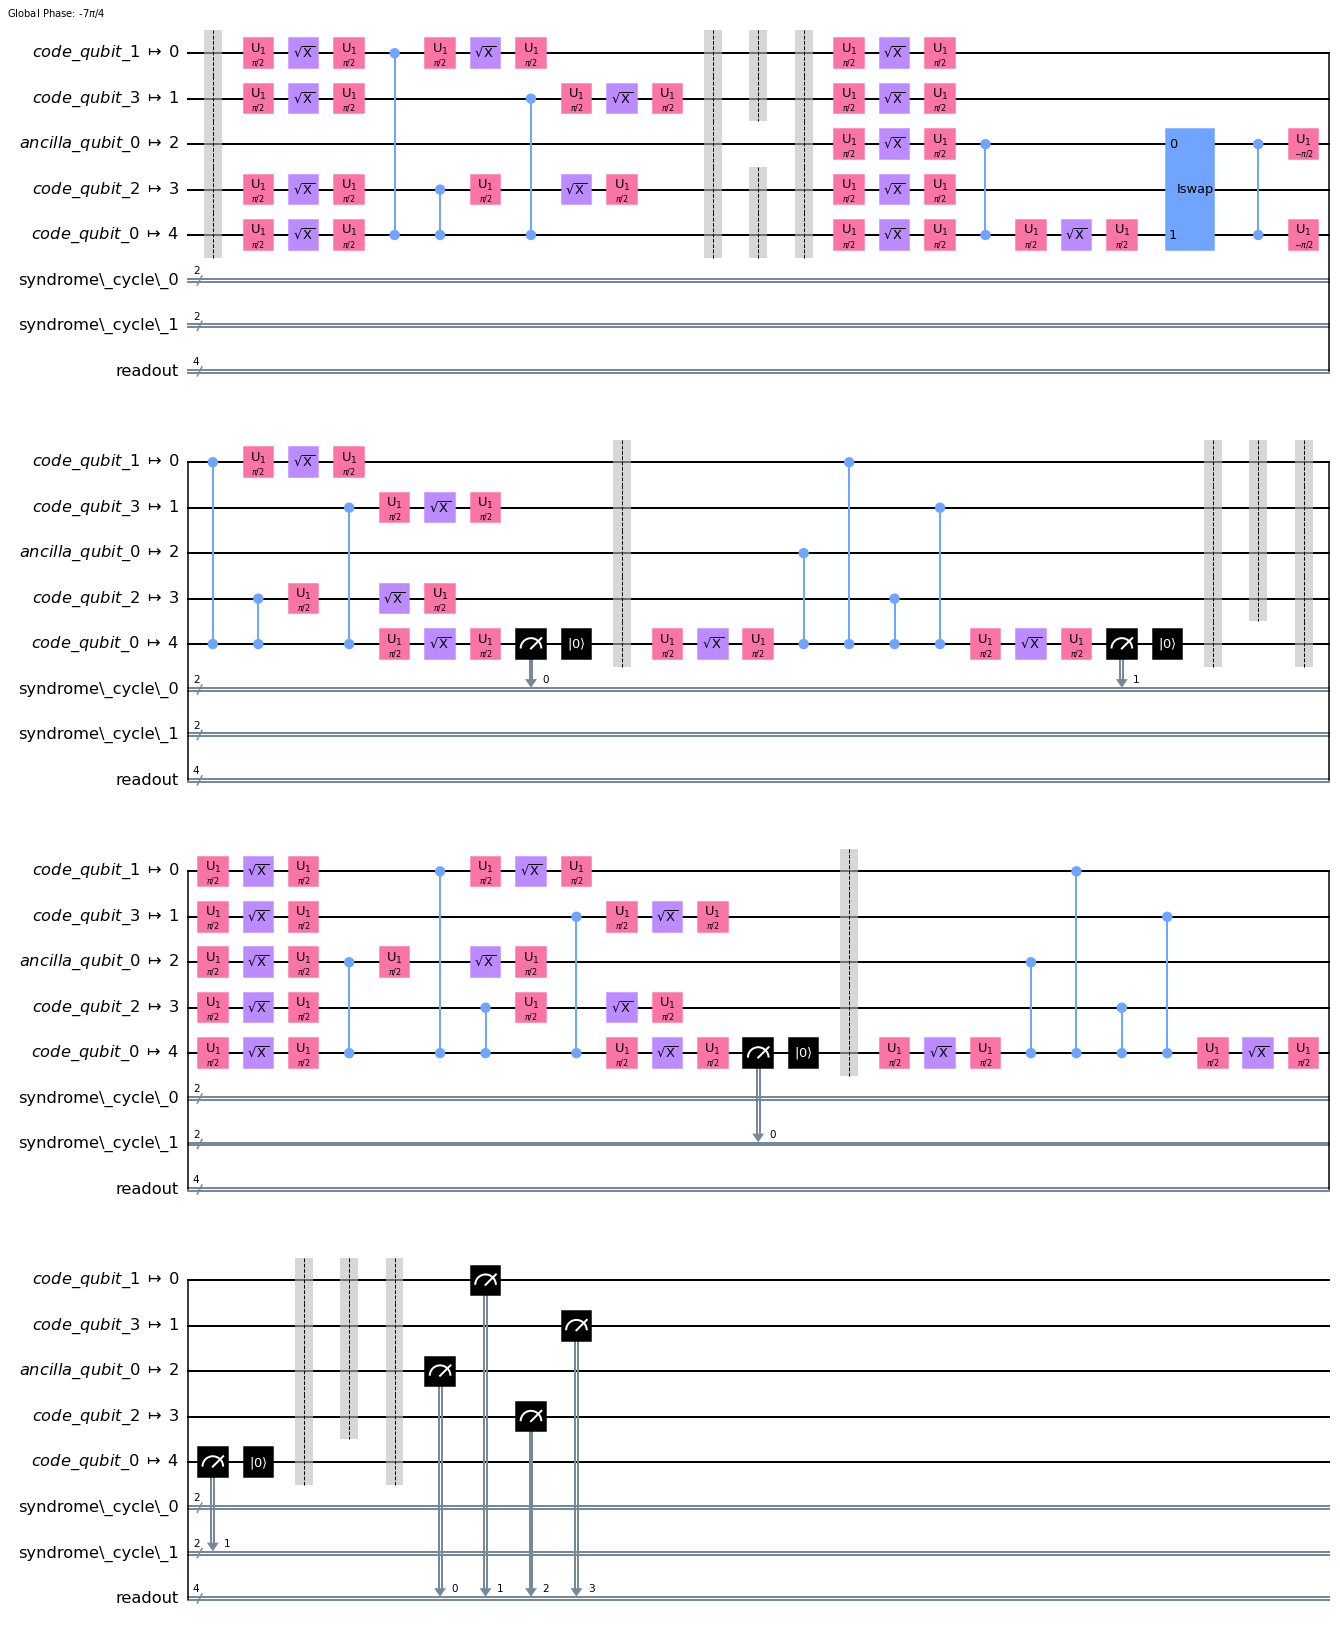

In [5]:
circ_t = shortest_transpile_from_distribution(circ, print_cost=False, **cross_device_properties)
circ_t.draw(output='mpl')

While this looks alot more messy, but it does what we want it to. To the left the arrows indicate how the circuit qubits are assigned to the physical qubits i.e. 'code_qubit_0' is assigned to physical qubit '4'. Inspecting the circuit, we see that '4' represents the center qubit with full connectivity, and if we look at the circuit before transpilation, 'code_qubit_0' requires such connectivity to encode the state. After the encoding is finished, the ancilla qubit now requires that connectivity and is swapped into the center, using iSWAP + CZ + U1. Note how the snapshots afterwards take this permutation of qubits into account.

We also noticed that Hadamard gates has been transpiled to a Z-rotation (labeled U1), followed by $\sqrt(X)$ and another Z-rotation. Similarly any CNOT gate is decomposed into a CZ with hadamards before and after.

# Qubit noise
In Qiskit, noise is generally added by creating a noise model, and passing it to the simulator when running simulation. This can include amplitude damping, phase damping, depolarizing channels and more. However, these are only applied during a gate. We also want to want to add thermal relaxation to idle qubits. To do this, we must add it directly to our circuit.

Luckily, we have created the function *add_idle_noise_to_circuit()* which does exactly this. We only need to define our gate times, T1, and T2. We set $T_1 = 40 \mu s$ and $T_2 = 60 \mu s$. Gate times are predefined in *standard_times*  and set to $20ns$ for single qubit gates, $100ns$ for two-qubit gates and $300ns$ for measurements. Z-rotations (such as U1) are made instant, due to the virtual-Z gate.

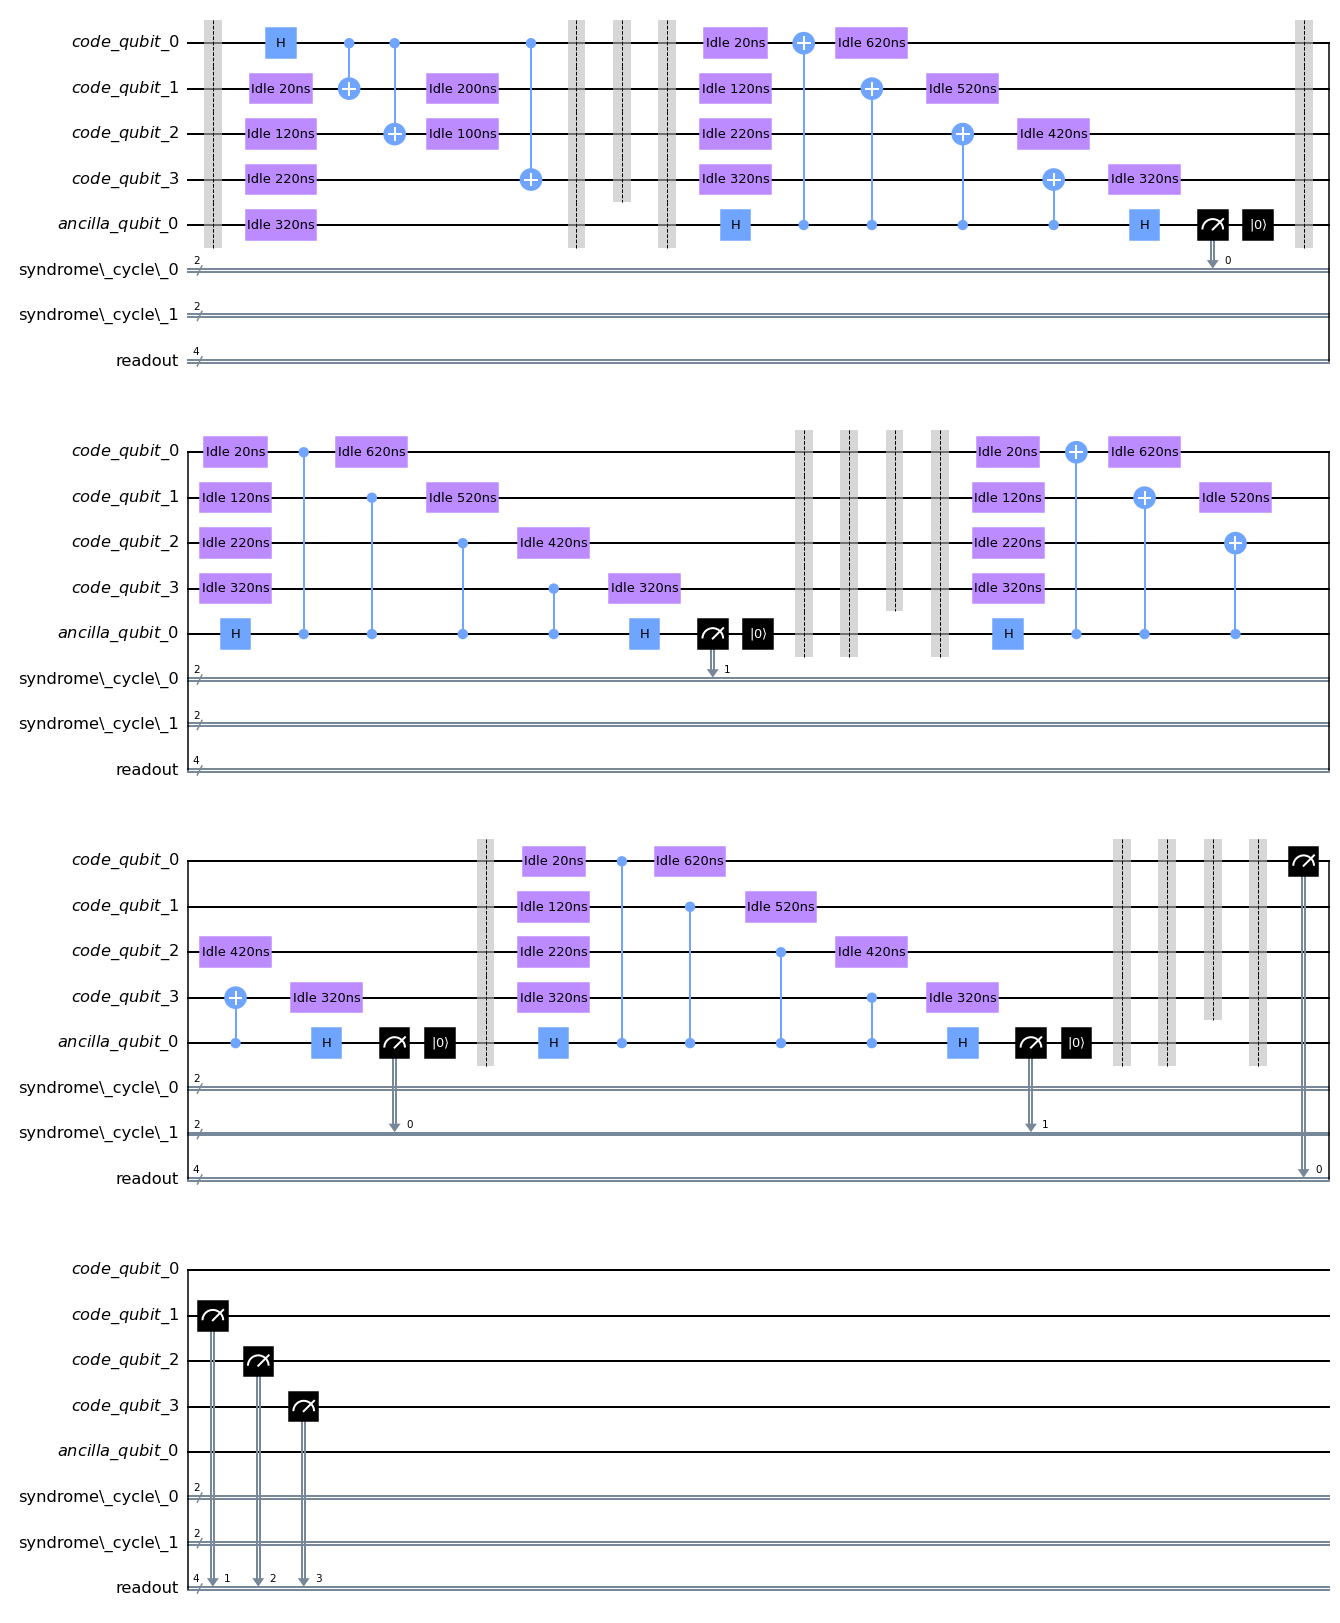

In [6]:
# Add idle noise
T1=40e3
T2=60e3
circ_idle_noise = add_idle_noise_to_circuit(circ, gate_times=standard_times,
                                                  T1=T1, T2=T2, rename=True)
circ_idle_noise.draw(output='mpl')

Note that we used the pre-transpiled circuit to do this. This only acts as an example for clarity. We also used the argument rename=True, which renames the idle-noise gates to show the idling time they represent. The simulator will not be able to interpret these names, and are only done to quickly verify that everything is working.

Now, we add the idle noise 'correctly', so it can be used in simulation

In [7]:
# Add idle noise
circ_i, time = add_idle_noise_to_circuit(circ_t, gate_times=standard_times,
                                         T1=T1, T2=T2, rename=False,
                                         return_time=True)
print(time) # Time contains a dict of the time of snapshots in the circuit and their name                                  


{'dm_con_0': 340, 'dm_con_1': 2040, 'dm_con_2': 3520, 'end': 3820}


Now we're ready to simulate the circuit. We only need to define a noise model. For these simulations we only use amplitude- and phase damping on all qubits. We quickly define this using our local function *thermal_relaxation_V2()* defined in *custom_noise_model.py*.

In [8]:
# Define a noise model
noise_model = thermal_relaxation_model_V2(T1=T1, T2=T2, gate_times=standard_times)

# Settings for the simulator
n_shots = 2048 # Number of runs
simulator = Aer.get_backend('qasm_simulator')
simulator.set_option('method', 'density_matrix')

# Run the circuit
results = execute(circ_i, simulator, noise_model=noise_model, shots=n_shots).result()
print(results.data().keys())

dict_keys(['counts', 'dm_con_1', 'dm_con_2', 'dm_con_0'])


The results object contains all the data from the simulation, which includes
- Counts of all measurement outcomes at the end of circuit
- Density matrix snapshots after each cycle, conditioned on measurement outcomes up until that point

We're generally intreseted in the snapshots. Looking at the keys printed above, we have three snapshots, labeled 'dm_con_{number}'.
0 is the first snapshot, directly after encoding while 1 and to are after the first and second stabilizer cycle respectively.

In [9]:
print('0th snapshot keys: \n',results.data()['dm_con_0'].keys())
print('1st snapshot keys: \n',results.data()['dm_con_1'].keys())

0th snapshot keys: 
 dict_keys(['0x0'])
1st snapshot keys: 
 dict_keys(['0x1', '0x3', '0x0', '0x2'])


Here we see the different outcomes measured at each snapshot. At the 0th, we have no measurements done, and such everything falls under the outcome '0' (or '0x0' as its written in hexadecimal)

After the first cycle, we have four outcomes, based on the stabilizer measurements. Measuring the two stabilizers XXXX and ZZZZ gives us either 00, 01, 10 or 11 --> 0x0, 0x1, 0x2 or 0x3. Note that in Qiskit these are read backwards, to that the lates measurement is the most significant number.

# Post-selection
Since $[[4,2,2]]$ is an error detecting code, it makes sense that we post-select away the runs where any stabilizers gave a -1 eigenvalue i.e. detected an error. Since our snapshots are conditioned on measurement outcomes, we simple disregard any snapshot that does not have the '0x0' key. This is done using *get_trivial_post_select_den_mat()*, which returns a list of all the snapshots.

In [10]:
# Get the statevector corresponding to the pure, desired state.
trivial_state = get_encoded_state_422(initial_state, include_ancillas=None)
fidelities = []

# Calculate the number of remaining runs at each snapshot
select_counts = get_trivial_post_select_counts(results.get_counts(), n_cycles, '00')

i=0
for state in get_trivial_post_select_den_mat(results, n_cycles, '00'):
    fidelities.append(state_fidelity(state, trivial_state))
    print('Snapshot '+str(i)+', fidelity: ', fidelities[i], ', Remaining runs: ', select_counts[i])
    i+=1

Snapshot 0, fidelity:  0.9827349961585947 , Remaining runs:  2048
Snapshot 1, fidelity:  0.9546124894380954 , Remaining runs:  1877
Snapshot 2, fidelity:  0.9539839293791588 , Remaining runs:  1696


From this we already see that the number of runs without detected errors quickly falls of. Also, while the 0th snapshot (after encoding) does not have perfect fidelity, all runs remain as we have not performed any measurement to detect the presence of these errors.

We also see that the fidelity (somewhat) stays at 0.95 between the two cycles. This is due to the somewhat simplistic noise model. With no measurement errors, we always post-select (almost) perfectly. The errors undetected are Z-errors which happened after measuring XXXX (seeing as we measure XXXX first in a cycle, the snapshot is instantly after the ZZZZ measurement)

We now proceed to the results/actual simulations. This will not be as detailed as previous sections.

# Repeated error detection
First we perform error detection for a large amount of cycles. We also compare this to the decay of the qubit state and fraction of error-free runs.

In [11]:
# Simulation (might take a minute or two to run)

n_cycles=20
n_shots = 1024*4
kwargs = {
    'reset': True,
    'encoding': False,
    'conditional': True,
    'include_barriers': True,
    #'extra_snapshots': True,
    'snapshot_type': 'dm',
    #'final_measure': False,
    'project': True,
    }

# Run simulations for all four computational (logical) states
fid_L_00, P_L_00, counts_00, times = fidelity_from_scratch_422(n_cycles, n_shots,
                                    initial_state = [1.,0.,0.,0.], **kwargs)
fid_L_01, P_L_01, counts_01, times = fidelity_from_scratch_422(n_cycles, n_shots,
                                    initial_state = [0.,1.,0.,0.], **kwargs)
fid_L_10, P_L_10, counts_10, times = fidelity_from_scratch_422(n_cycles, n_shots,
                                    initial_state = [0.,0.,1.,0.], **kwargs)
fid_L_11, P_L_11, counts_11, times = fidelity_from_scratch_422(n_cycles, n_shots,
                                    initial_state = [0.,0.,0.,1.], **kwargs)

We compare simulations with the case of no stabilizers, where the logical state is prepared and left idle for some time. To create this data, we define a function get_idle_encoded_422

In [12]:
def get_idle_encoded_422(snapshot_times, snapshot_type='dm', T1=40e3, T2=60e3,
                         initial_state=[1., 0., 0., 0.], pauliop='ZZZZZ'):
    circ = QuantumCircuit(4)
    initial_state = get_encoded_state_422(initial_state, include_ancillas=None)
    circ.set_density_matrix(initial_state)
    time_passed = 0
    for i, time in enumerate(snapshot_times):
        time_diff = time-time_passed
        if time_diff > 0:
            thrm_relax = thermal_relaxation_error(
                T1, T2, time_diff).to_instruction()
            for qubit in circ.qubits:
                circ.append(thrm_relax, [qubit])

        add_snapshot_to_circuit(circ, snapshot_type, i,
                                circ.qubits, conditional=False, pauliop=pauliop)
        time_passed = time

    simulator = Aer.get_backend('aer_simulator')
    simulator.set_option('method', 'density_matrix')
    results = execute(circ, simulator,
                      noise_model=None, shots=1).result()
    return results

In [14]:
#%% Encoded idle decay
# We extract 41 datapoints evenly distributed between 0ns and 1480*20ns (20 cycles)
n_datapoints = 41
snapshot_times = np.linspace(0,1480*20, n_datapoints)

# Run simulation
res_00 = get_idle_encoded_422(snapshot_times, initial_state=[1., 0., 0., 0.])
res_01 = get_idle_encoded_422(snapshot_times, initial_state=[0., 1., 0., 0.])
res_10 = get_idle_encoded_422(snapshot_times, initial_state=[0., 0., 1., 0.])
res_11 = get_idle_encoded_422(snapshot_times, initial_state=[0., 0., 0., 1.])

# Pure logical states
pure_logicals = logical_states_422(include_ancillas=None)

# Calculate fidelity
fid_00_d = [state_fidelity(pure_logicals[0b00], res_00.data()['dm_'+str(index)]) 
            for index in range(n_datapoints)]
fid_01_d = [state_fidelity(pure_logicals[0b01], res_01.data()['dm_'+str(index)]) 
            for index in range(n_datapoints)]
fid_10_d = [state_fidelity(pure_logicals[0b10], res_10.data()['dm_'+str(index)])
            for index in range(n_datapoints)]
fid_11_d = [state_fidelity(pure_logicals[0b11], res_11.data()['dm_'+str(index)])
            for index in range(n_datapoints)]

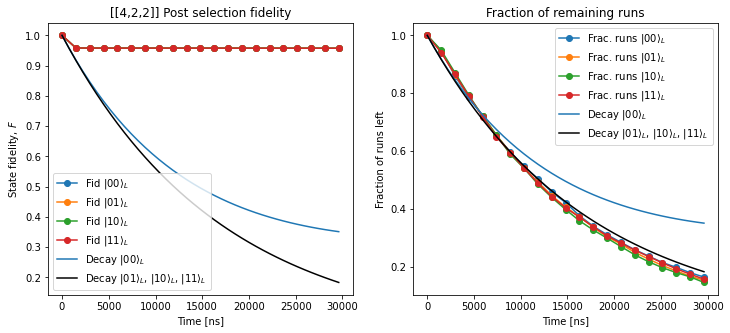

In [17]:
#%% Plot post-selection
fid_00 = []
fid_01 = []
fid_10 = []
fid_11 = []
for i in range(n_cycles+1):
    fid_00.append(fid_L_00[i]*P_L_00[i])
    fid_01.append(fid_L_00[i]*P_L_00[i])
    fid_10.append(fid_L_00[i]*P_L_00[i])
    fid_11.append(fid_L_00[i]*P_L_00[i])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
t_cycles = np.array([times['dm_con_'+str(i)] for i in range(n_cycles+1)])
ax[0].plot(t_cycles, fid_00, '-o', color='C0', label=r'Fid $|00\rangle_L$')
ax[0].plot(t_cycles, fid_01, '-o', color='C1', label=r'Fid $|01\rangle_L$')
ax[0].plot(t_cycles, fid_10, '-o', color='C2', label=r'Fid $|10\rangle_L$')
ax[0].plot(t_cycles, fid_11, '-o', color='C3', label=r'Fid $|11\rangle_L$')

ax[0].plot(snapshot_times, fid_00_d, color='C0', label=r'Decay $|00\rangle_L$')
ax[0].plot(snapshot_times, fid_01_d, color='k', label=r'Decay $|01\rangle_L$, $|10\rangle_L$, $|11\rangle_L$')
ax[0].set_xlabel('Time [ns]')
ax[0].set_ylabel(r'State fidelity, $F$')
ax[0].set_title('[[4,2,2]] Post selection fidelity')
ax[0].legend()

frac_00 = []
frac_01 = []
frac_10 = []
frac_11 = []
for i in range(n_cycles+1):
    frac_00.append(counts_00[i]/n_shots)
    frac_01.append(counts_01[i]/n_shots)
    frac_10.append(counts_10[i]/n_shots)
    frac_11.append(counts_11[i]/n_shots)
ax[1].plot(t_cycles, frac_00, '-o', color='C0', label=r'Frac. runs $|00\rangle_L$')
ax[1].plot(t_cycles, frac_01, '-o', color='C1', label=r'Frac. runs $|01\rangle_L$')
ax[1].plot(t_cycles, frac_10, '-o', color='C2', label=r'Frac. runs $|10\rangle_L$')
ax[1].plot(t_cycles, frac_11, '-o', color='C3', label=r'Frac. runs $|11\rangle_L$')

ax[1].plot(snapshot_times, fid_00_d, color='C0', label=r'Decay $|00\rangle_L$')
ax[1].plot(snapshot_times, fid_01_d, color='k', label=r'Decay $|01\rangle_L$, $|10\rangle_L$, $|11\rangle_L$')


ax[1].set_xlabel('Time [ns]')
ax[1].set_ylabel(r'Fraction of runs left')
ax[1].set_title('Fraction of remaining runs')
ax[1].legend()

The results we get are quite logical.
- The number of error-free runs decays exponentially with time (Right plot)
- This fraction matches the decay of the pure logical states (except $\ket{00}_L$)
- The fidelity is stable at $\sim 0.95$

The last point is most probably due to our noise model; without measurement errors the readout is perfect, and neither does our noise model encompass any accumulating errors.

# Encoding fidelity
This section calculates and presents the fidelity of the four computational logical states $\ket{00}_L$, $\ket{01}_L$, $\ket{10}_L$ and $\ket{11}_L$. Its fidelity is measured both as the state fidelity, but also the probability of measuring the correcting logical state, wrong logical state, or any state outside of the code space. We also group the encoding into three categories: Without transpilation, transpiling to the gate set, and transpiling to connectivity + gate set. The last one includes the swapping of qubits at the end, required to start running stabilizer measurements.

We do this by creating a function similar to *fidelity_from_scratch_422()*; it builds the desired circuit, runs simulations on it, processes the results and return them.

The encoding is done by starting in the $\ket{0000}$ state and performing a hadamard on the 0th qubit, followed by three CNOT gates to entangle all four qubits. This corresponds to the $\ket{00}_L} state, and for any other state we then perform any necessary logical bit-flips.

In [18]:
# Function for running encoding and calculating fidelity
def encoding_fidelity_422(n_shots, gate_times={}, T1=40e3, T2=60e3,
                          idle_noise=True, initial_state=[1,0,0,0],
                          include_swap=False, transpile=False,
                          snapshot_type='dm', project=False, 
                          measure_readout=True, **kwargs):

    # Get gate times missing from input
    if isinstance(gate_times, dict):
        full_gate_times = standard_times.get_gate_times(
            custom_gate_times=gate_times)
    elif isinstance(gate_times, GateTimes):
        full_gate_times = gate_times
    else:
        warnings.warn('Invalid gate times, assuming standard_times')
        full_gate_times = standard_times

    # Registers
    qb = QuantumRegister(4, 'code_qubit')
    an = AncillaRegister(1, 'ancilla_qubit')
    cr = get_classical_register_422(0)
    readout = ClassicalRegister(4, 'readout')
    registers = StabilizerRegisters(qb, an, cr, readout)

    # Circuits
    circ = get_empty_stabilizer_circuit_422(registers)

    # Encoding
    circ.compose(encode_input_422(registers, initial_state=initial_state,
                 include_swap=include_swap, **kwargs),
                 inplace=True)
    if include_swap:
        qubits = [an[0], qb[1], qb[2], qb[3], qb[0]]  # Qubit permutation
    else:
        qubits = qb
    add_snapshot_to_circuit(circ, snapshot_type=snapshot_type, current_cycle=0,
                            qubits=qubits, **kwargs)

    # Optional measurement of output
    if measure_readout:
        if include_swap:
            circ.measure([an[0],qb[1], qb[2], qb[3]], readout)
        else:
            circ.measure(qb, readout)

    # Transpile
    if transpile:
        circ = shortest_transpile_from_distribution(circ, print_cost=False)

    # Trivial state
    if snapshot_type == 'dm' or snapshot_type == 'density_matrix':
        trivial_res = execute(circ, Aer.get_backend(
            'qasm_simulator'), shots=1).result()
        trivial = trivial_res.data()['dm_0']

    # Add idle noise
    if idle_noise:
        circ, time = add_idle_noise_to_circuit(circ, gate_times=full_gate_times,
                                               T1=T1, T2=T2, return_time=True)
    else:
        time = {'end': None}

    # Run the circuit
    noise_model = thermal_relaxation_model_V2(
        T1=T1, T2=T2, gate_times=full_gate_times)
    results = execute(circ, Aer.get_backend('qasm_simulator'),
                      noise_model=noise_model, shots=n_shots).result()

    # Analyze results
    if snapshot_type == 'dm' or snapshot_type == 'density_matrix':
        state = results.data()['dm_0']
        
        if project:
            state, P_L = project_dm_to_logical_subspace_422(
                state, return_P_L=True)
            state = get_encoded_state_422(np.diag(state), include_ancillas=None)
        fidelities = state_fidelity(state, trivial)
        if project:
            return fidelities, circ, time['end'], P_L
    elif snapshot_type == 'exp' or snapshot_type == 'expectation_value':
        fidelities = results.data()['exp_0']

    return fidelities, circ, results, time['end']

In [22]:
#%% Run simulations (Might take a minute or two to run)
n_shots=1e6 # Number of runs
fid_list = []
circ_list = []
res_list = []
times_list = []
state_list = [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1] ]

include_swap_settings = [False, False, True]
transpile_settings = [False, True, True]
for j in range(3): # Iterate over 3 different settings
    for i in range(4): # Iterate over 4 logical states
        # Run simulation
        fid, circ, res, times = encoding_fidelity_422(n_shots, gate_times={},
                          T1=40e3, T2=60e3,
                          idle_noise=True, initial_state=state_list[i], 
                          include_swap=include_swap_settings[j],
                          transpile=transpile_settings[j],
                          snapshot_type='dm', project=False)
        # Append results
        fid_list.append(fid)
        circ_list.append(circ)
        res_list.append(res)
        times_list.append(times)   

In [33]:
#%% Print LaTeX table of probabilitiy of
#   correctly measured & incorrect logical & syndrome measured
outcomes = [bin(i)[2:].zfill(4) for i in range(16)]
syndrome_idx = [1,2,4,7,8,11,13,14]

# Group runs based on results
index = 0
state_list = ['00', '01', '10', '11']
for j in range(3):
    print('Encoding with transpile =',transpile_settings[j],' and swap_at_end =',include_swap_settings[j])
    print('Encoded state \tCorrect state \tWrong logical \tSyndrome state \tState fidelity')
    for i in range(4):
        group_counts = [0,0,0]
        counts = res_list[index].get_counts()
        for key in outcomes:
            if key not in counts.keys():
                counts[key] = 0
 
        # List of list of indexes for the correct logical state in base 10
        # i.e. 0 -> 0000, 15 -> 1111
        logical_idx = [[0,15], [3,12], [5,10], [6,9]]

        # Correct measurements
        correct_idx = logical_idx.pop(i)
        for idx in correct_idx:
            group_counts[0] += counts[outcomes[idx]]

        # Wrong logical state measured
        for entry in logical_idx:
            for idx in entry:
                group_counts[1] += counts[outcomes[idx]]

        # State outside code space measured
        for idx in syndrome_idx:
            group_counts[2] += counts[outcomes[idx]]

        # Print results as LaTeX table input
        print('State: '+state_list[i]+'\t&', group_counts[0]/n_shots, '\t& ', group_counts[1]/n_shots,  \
              '\t& ',group_counts[2]/n_shots, ' \\\\ \\hline')
        index += 1
    print('\n')

Encoding with transpile = False  and swap_at_end = False
Encoded state 	Correct state 	Wrong logical 	Syndrome state
State: 00	& 0.974269 	&  0.00167 	&  0.024061  \\ \hline
State: 01	& 0.966419 	&  0.001525 	&  0.032056  \\ \hline
State: 10	& 0.968466 	&  0.001445 	&  0.030089  \\ \hline
State: 11	& 0.971011 	&  0.001431 	&  0.027558  \\ \hline


Encoding with transpile = True  and swap_at_end = False
Encoded state 	Correct state 	Wrong logical 	Syndrome state
State: 00	& 0.971593 	&  0.001604 	&  0.026803  \\ \hline
State: 01	& 0.971936 	&  0.001401 	&  0.026663  \\ \hline
State: 10	& 0.971243 	&  0.001438 	&  0.027319  \\ \hline
State: 11	& 0.971295 	&  0.001474 	&  0.027231  \\ \hline


Encoding with transpile = True  and swap_at_end = True
Encoded state 	Correct state 	Wrong logical 	Syndrome state
State: 00	& 0.960839 	&  0.002077 	&  0.037084  \\ \hline
State: 01	& 0.960453 	&  0.001679 	&  0.037868  \\ \hline
State: 10	& 0.960105 	&  0.001659 	&  0.038236  \\ \hline
State: 11	&

We can also print the circuits for clarity. The 'Kraus' gates corresponds to idle noise added to the circuits

In [35]:
index = 0
for i in range(3):
    print('Circuit with transpile =',transpile_settings[j],' and swap_at_end =',include_swap_settings[j])
    print(circ_list[index])
    index+=4

Circuit with transpile = True  and swap_at_end = True
                   ┌───┐                           ░  ░  ░ ┌─┐         
   code_qubit_0: ──┤ H ├────■────■─────────────■───░──░──░─┤M├─────────
                 ┌─┴───┴─┐┌─┴─┐  │  ┌───────┐  │   ░  ░  ░ └╥┘┌─┐      
   code_qubit_1: ┤ kraus ├┤ X ├──┼──┤ kraus ├──┼───░──░──░──╫─┤M├──────
                 ├───────┤└───┘┌─┴─┐├───────┤  │   ░  ░  ░  ║ └╥┘┌─┐   
   code_qubit_2: ┤ kraus ├─────┤ X ├┤ kraus ├──┼───░──░──░──╫──╫─┤M├───
                 ├───────┤     └───┘└───────┘┌─┴─┐ ░  ░  ░  ║  ║ └╥┘┌─┐
   code_qubit_3: ┤ kraus ├───────────────────┤ X ├─░──░──░──╫──╫──╫─┤M├
                 ├───────┤                   └───┘ ░  ░  ░  ║  ║  ║ └╥┘
ancilla_qubit_0: ┤ kraus ├─────────────────────────░─────░──╫──╫──╫──╫─
                 └───────┘                         ░     ░  ║  ║  ║  ║ 
      readout: 4/═══════════════════════════════════════════╩══╩══╩══╩═
                                                            0  1  2  3 
Circuit wi

# ERROR CLASSIFICATION
Generate data regarding the errors present in the qubit state at different points of the simulation. It is similar to the repeated QED section earlier, but instead we seek to classify the errors present

In [36]:
#%% Functions necessary
def reduce_key(key: str, current_snapshot: int, measurements_per_snapshot=1):
    """Cuts of the initial bits of a key to get the equivalent one at earlier cycles. 

    E.g. \n
    current_cycle = 1 \n
    '0xff' -> '11111111' -> '1111' - > '0xf'  \n
    current_cycle = 3 \n
    '0xff' -> '11111111' -> '11111111' -> '0xff' \n

    Args:
        key (str): Hex key for the measurement outcome
        current_snapshot (int): Index of the snapshot
        measurements_per_snapshot (int, optional): Number of measurements (to different cl registers) that takes place in between every snapshot. Defaults to one. If only one snap is take every cycle, set this to the number of stabilizers.

    Returns:
        reduced key (str): Hex key matching the current cycle.
    """
    return hex(int(bin(int(key, 16))[2:][:measurements_per_snapshot*current_snapshot].zfill(1), 2))

full_syndromes = [[(XGate, 0)],
                  [(XGate, 1)],
                  [(XGate, 2)],
                  [(XGate, 3)],
                  [(ZGate, 0)],
                  [(ZGate, 1)],
                  [(ZGate, 2)],
                  [(ZGate, 3)],
                  [(XGate, 0), (ZGate, 0)],
                  [(XGate, 1), (ZGate, 1)],
                  [(XGate, 2), (ZGate, 2)],
                  [(XGate, 3), (ZGate, 3)]]

def get_syndrome_basis():
    """Returns a basis set for every state outside of the code space of the
    [[4,2,2]] QED code.
    """

    logical_00 = Statevector(logical_states_422(None)[0])

    syndromes = [logical_00]*12

    for syndrome in range(len(syndromes)):  # Loop over possible errors
        for correction_strategy in full_syndromes[syndrome]:
            syndromes[syndrome-1] = syndromes[syndrome-1].evolve(
                    correction_strategy[0](), [correction_strategy[1]])

    return syndromes

In [37]:
# Set up circuit and simulate
kwargs = {
    'n_cycles': 20,
    'reset': True,
    'encoding': False,
    'conditional': True,
    'include_barriers': True,
    'initial_state': [1., 0., 0., 0.],
    'extra_snapshots': True,
    'snapshot_type': 'dm',
    'final_measure': False,

    }
gate_times = standard_times

# Get the complete circuit
circ = get_full_stabilizer_circuit_422(**kwargs)
circ, times = add_idle_noise_to_circuit(circ, gate_times, return_time=True)

#%% Run simulation
n_shots = 1024*2
#results = default_execute(circ, n_shots, gate_times=gate_times)
# Run the circuit
simulator = Aer.get_backend('qasm_simulator')
simulator.set_option('method', 'density_matrix')
results = execute(circ, simulator, noise_model=noise_model, shots=n_shots).result()

In [39]:
#%% Calculate density matrix overlap with the different basis states
time = np.empty(label_counter.value)
P_00 = np.empty(label_counter.value)  # Probability of being in |00>_L state
P_01 = np.empty(label_counter.value)  # Probability of being in |01>_L state
P_10 = np.empty(label_counter.value)  # Probability of being in |10>_L state
P_11 = np.empty(label_counter.value)  # Probability of being in |11>_L state
P_syn = np.empty(label_counter.value) # Probability of being in a syndrome state


logical = logical_states_422(include_ancillas=None)
key = '0x0'
for i in range(label_counter.value):
    label = get_snapshot_label('dm', kwargs['conditional'], i)
    if kwargs['conditional']:
        rho = results.data()[label][reduce_key(key, i)]
    else:
        rho = results.data()[label]
    time[i] = times[label]*1e-3

    P_00[i] = overlap_with_subspace(rho, logical[0b00])
    P_01[i] = overlap_with_subspace(rho, logical[0b01])
    P_10[i] = overlap_with_subspace(rho, logical[0b10])
    P_11[i] = overlap_with_subspace(rho, logical[0b11])
    P_syn[i] = overlap_with_subspace(rho, get_syndrome_basis())

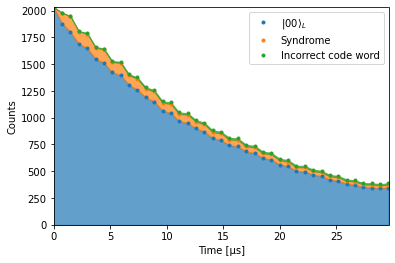

In [41]:
#%% Plotting

# Group all other logical states
P_other = P_01 + P_10 + P_11
order = np.array([P_00, P_syn, P_other])

data_points = [i for i in range(1, label_counter.value-1)]
if kwargs['conditional']:
    counts_at_snapshots = get_trivial_post_select_counts_V2(
        results.get_counts(),
        data_points,
        label_counter.value) 
else:
    counts_at_snapshots = np.ones(label_counter.value)

colors = plt.get_cmap("tab10")
for i in range(3):
    lower = order[:i].sum(axis=0)
    plt.fill_between(time, (order[i]+lower)*counts_at_snapshots, lower*counts_at_snapshots,
                     color=np.array(colors(i))-np.array([0, 0, 0, 0.3]))
    plt.plot(time, ((order[i]+lower)*counts_at_snapshots), '.', color=colors(i))


plt.ylabel('Number of remaining runs')

plt.xlabel('Time [μs]')
plt.ylim((0, counts_at_snapshots[0]))
plt.xlim((0, time[-1]))
plt.legend(labels=[r'$|00\rangle_L$', 'Syndrome', 'Other logical states'])

From this we see that we (within our noise model) rarely get a logical error, since the green area is almost indistinguishable. This might not be the case with less forgiving noise. We also notice that while post-selecting runs away, we are still not entirely within the code space. This is probably due to errors occuring between the stabilizers. While we measure for bit-flip errors, phase-flips go undetected and vice versa.

There is also a significantly steeper dip every other data point. Each point corresponds to a snapshot, taken directly after a stabilizer measurement. The difference may be due to choosing $T_1=40\mu s$ and $T_2=60\mu s$, leaving the qubits more prone to bit-flip errors.

# TRANSVERSAL GATES

As the final part, we highlight some possible logical gates for the encoded state. Several of these gates can be found in the paper by Robin Harper & Steven T. Flammia, 2019 (https://arxiv.org/abs/1806.02359).

These gates can be quickly created using functions in *logical_gates_422.py*

Most of the logical gates only require either single-qubit gates, or a re-indexing of qubits, or both.

As an example, a logical CNOT only requires a single SWAP gate

In [4]:
circ = logical_CNOT(0,1)
circ.draw()

q2_0: ───
         
q2_1: ───
         
q2_2: ─X─
       │ 
q2_3: ─X─

However, these can also be made instant by simply relabeling our logical states from

$$\ket{10}_L=\frac{\ket{0101}+\ket{1010}}{\sqrt{2}}, \quad \ket{11}_L=\frac{\ket{1001}+\ket{0110}}{\sqrt{2}} $$ 
to 
$$\ket{10}_L=\frac{\ket{1001}+\ket{0110}}{\sqrt{2}}, \quad \ket{11}_L=\frac{\ket{0101}+\ket{1010}}{\sqrt{2}}. $$

Since the $[[4,2,2]]$ code does not distinguish between the logical states in itself, this does not have any effet on the state, only following operations need to be adjusted to the new correspondences.



Instead moving to the CZ gate, it can be implemented using two CZ in the following way

In [5]:
circ = logical_CZ()
circ.draw()

q3_0: ────■─
          │ 
q3_1: ─■──┼─
       │  │ 
q3_2: ─■──┼─
          │ 
q3_3: ────■─

This however, might not follow the desired connectivity of having an ancilla in the middle. Another simpler way of performing it is by applying the S gate on all four qubits, which corresponds to a logical CZ followed by Z on both logical qubits. The latter can then be reversed by applying a logical Z on both qubits

In [7]:
circ = QuantumCircuit(4)
circ.s([0,1,2,3])
circ.compose(logical_Z(2), inplace=True)
circ.draw()

┌───┐     
q_0: ┤ S ├─────
     ├───┤┌───┐
q_1: ┤ S ├┤ Z ├
     ├───┤├───┤
q_2: ┤ S ├┤ Z ├
     ├───┤└───┘
q_3: ┤ S ├─────
     └───┘

Finally, we mention the logical iSWAP, which is not presented in the article. It can simply be realized with a single iSWAP gate

In [8]:
circ = logical_iSWAP()
circ.draw()


┌────────┐
q5_0: ┤0       ├
      │        │
q5_1: ┤        ├
      │  ISWAP │
q5_2: ┤        ├
      │        │
q5_3: ┤1       ├
      └────────┘

However, this might not fit the desired connectivity and the phase introduced could prevent any relabeling. While a simple single-qubit gate representation might be possible for the iSWAP, one can also effectively implement it between stabilizer cycles. As iSWAP can be decomposed into SWAP + CZ + S on both qubits, we can perform the final two-qubit gate of our ZZZZ stabilizer using iSWAP, effectively incorporating a SWAP into the operation. Thus the desired connectivity can be achieved requiring only single qubit gates to adjust for the 'S' part of the iSWAP. This will not be demonstrated here, but merely mentioned